In [159]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import missingno
import seaborn as sns
import math

import collections
# from pydot import Dot, Node, Edge

# Managing Warnings 
import warnings
warnings.filterwarnings('ignore')

# Plot the Figures Inline
%matplotlib inline

In [160]:
data_df = pd.read_csv('train.csv', index_col=0) # 엑셀 파일 읽기

### 날짜 관련 열 전처리

##### 처리 열
1. 'DAYS_BIRTH'열 삭제 -> 'Age'열 추가: 'DAYS_BIRTH'열 양수 변환 후 /365
2. 'DAYS_EMPLOYED'열 -> 양수 값은 0으로 변환, 음수 값은 양수로 변환
3. 'begin_month'열 음수 -> 양수로 변경


In [161]:
data_df['Age'] = data_df['DAYS_BIRTH'].apply(lambda x : np.abs(x)/365)
data_df['DAYS_EMPLOYED'] = data_df['DAYS_EMPLOYED'].apply(lambda x: 0 if x > 0 else np.abs(x))
data_df['begin_month'] = data_df['begin_month'].apply(np.abs)
data_df = data_df.drop(['DAYS_BIRTH'],axis=1)

### bianry 열 처리
값을 (0,1) 만 가지도록 처리

In [162]:
gender_dict = {"F":0,"M":1}
car_dict = {"N":0,"Y":1}
reality_dict = {"N":0,"Y":1}
data_df['gender'] = [gender_dict[g] for g in data_df['gender']]
data_df['car'] = [car_dict[g] for g in data_df['car']]
data_df['reality'] = [reality_dict[g] for g in data_df['reality']]

### 기타 전처리
1. 'income_total'열 로그스케일링하지 않음 : 뒤에서 standard scaling 적용하므로
2. 'FLAG_MOBIL'열 삭제: 모든 행이 같은 값을 가짐

In [163]:
# data_df['income_total'] = data_df['income_total'].apply(lambda x: np.log1p(1+x))

In [164]:
print(data_df['FLAG_MOBIL'].value_counts())
data_df = data_df.drop(['FLAG_MOBIL'],axis=1)

1    26457
Name: FLAG_MOBIL, dtype: int64


### 한 사람이 여러 장의 카드를 산 경우를 파악할 수 있는 열 추가

카드를 구입한 시기와 관련된 'begin_month'열과, label에 해당하는 'credit'열을 제외한 나머지 열들의 값들로 행 중복 여부를 확인한 결과
한사람이 여러장의 카드를 산 경우가 있음을 확인

##### 처리 방법
1. 여러 장을 산 경우 1을 표기하는 열 'dup' 생성
2. 몇장을 샀는지 표기하는 열 'cards' 생성

In [165]:
data_df.head(3)

,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_EMPLOYED,work_phone,phone,email,occyp_type,family_size,begin_month,credit,Age
index,,,,,,,,,,,,,,,,,,
0,0,0,0,0,202500.0,Commercial associate,Higher education,Married,Municipal apartment,4709,0,0,0,NaN,2.0,6.0,1.0,38.079452
1,0,0,1,1,247500.0,Commercial associate,Secondary / secondary special,Civil marriage,House / apartment,1540,0,0,1,Laborers,3.0,5.0,1.0,31.178082
2,1,1,1,0,450000.0,Working,Higher education,Married,House / apartment,4434,0,1,0,Managers,2.0,22.0,2.0,52.293151


In [166]:
# 중복된 행이 있는지 확인
data_df.drop(['begin_month','credit'],axis=1).duplicated(subset=None,keep='first').value_counts()

True     17698
False     8759
dtype: int64

위 결과로부터 8759명의 유저가 고유 유저임을 확인 할 수 있었음

In [167]:
# 고유 id 열 생성
data_df['id'] = pd.factorize(data_df.drop(['begin_month','credit'],axis=1).apply(tuple, axis=1))[0] + 1

# 중복된 카드가 있는지 여부
data_df['dup'] =data_df.drop(['begin_month','credit'],axis=1).duplicated(subset=None,keep=False)
data_df['dup']=data_df['dup'].astype(int)

# 각 id마다 가지고 있는 카드 수 세기
tmp_dict = pd.DataFrame(data_df.id.value_counts()).to_dict('dict')
tmp_dict = tmp_dict.get('id')

data_df['cards'] = data_df['id'].apply(lambda  x:tmp_dict[x] )

# id는 삭제 (id에서 나오는 인사이트 확인 위해 지우지 않음 0509 083100)
data_df=data_df.drop(['id'],axis=1)

### 결측치 채우기

<AxesSubplot:>

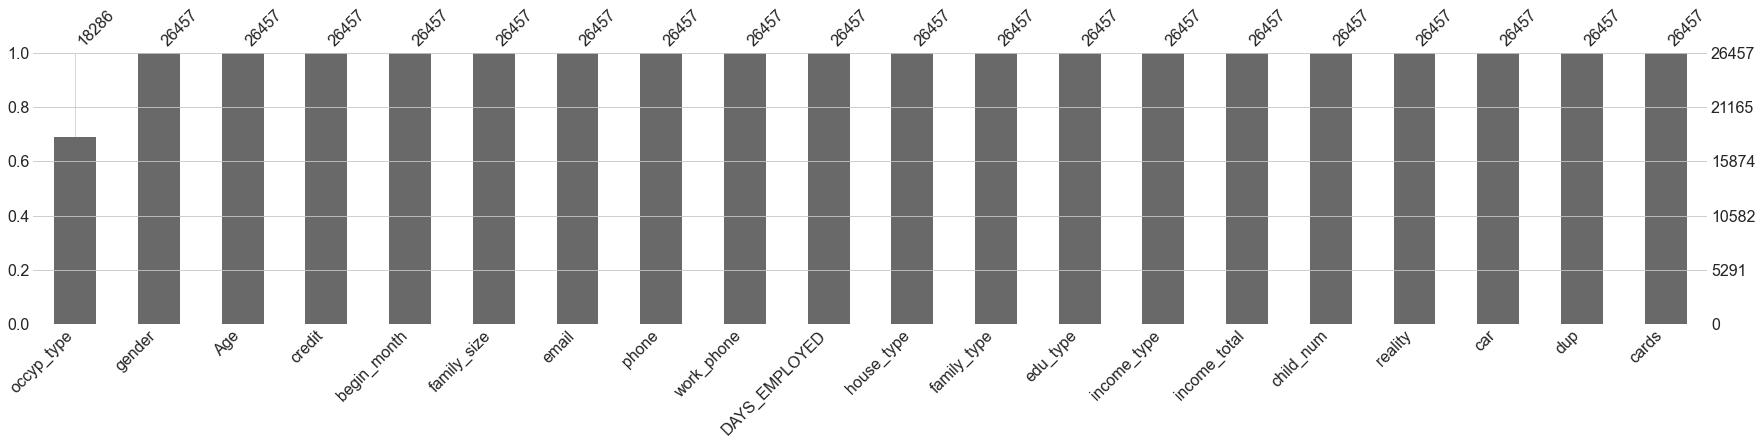

In [168]:
missingno.bar(data_df, sort='ascending', figsize = (30,5))

In [169]:
# 1. 무직자는 Unemployed 처리
data_df.loc[(data_df['DAYS_EMPLOYED'] == 0) & (data_df['occyp_type'].isnull()), 'occyp_type'] = 'Unemployed'

##### income_type 별로 가장 많은 occyp_type을 찾아서 NaN값의 결측치를 채우기

In [170]:
# 방법 1. 나머지는 income_type 별로 가장 많은 occyp_type을 찾아서 NaN값의 결측치를 채우기
fillvalues = data_df.groupby('income_type').occyp_type.apply(lambda x: x.mode())
for i in range(len(data_df)):
    if pd.isna(data_df['occyp_type'][i]):
        data_df['occyp_type'][i] =  fillvalues[data_df['income_type'][i]][0]

# missingno.bar(data_df, sort='ascending', figsize = (30,5))

#####  대안2: ~직업열 외의 feature로 머신러닝하여 결측치 채우기~

In [58]:
##방법 1로 선택되어 방법 2 코드를 주석처리하였습니다.
## 방법 2:  나머지는 머신러닝을 통해 결측치 채우기
# from sklearn.preprocessing import OneHotEncoder, StandardScaler
# from sklearn.compose import ColumnTransformer
# from sklearn.pipeline import Pipeline
# from sklearn import preprocessing
# from sklearn.metrics import accuracy_score

# from sklearn.ensemble import GradientBoostingClassifier

# # occyp_type 전처리 위한 occyp_df 생성
# occyp_df = data_df.copy()
# occyp_df = occyp_df.drop(columns='credit', axis = 0)

# # occyp_df열 분류를 위한 feature 열만 남기기
# occyp_df = occyp_df[['occyp_type','Age','income_total','income_type','edu_type','house_type', 'work_phone','gender','car','reality']]

# occyp_notnull_df = occyp_df[occyp_df['occyp_type'].notnull()]
# occyp_isnull_df = occyp_df[occyp_df['occyp_type'].isnull()]
# del occyp_isnull_df['occyp_type']


# # null 값이 없는 df를 train X, y label로 나누기
# X_train = occyp_notnull_df.drop(['occyp_type'],axis=1)
# y_train = occyp_notnull_df['occyp_type']

# numeric_features = ['income_total','Age']
# numeric_transformer = StandardScaler() 

# categorical_features = ['income_type','edu_type','house_type']
# categorical_transformer = OneHotEncoder() 

# pass_through = ['gender','car','reality','work_phone']

# preprocessor = ColumnTransformer(
#     transformers=[ # List of (name, transformer, column(s))
#         ('num', numeric_transformer, numeric_features),
#         ('cat', categorical_transformer, categorical_features),
#         ('pass_through','passthrough',pass_through)])

# preprocessor_pipe = Pipeline(steps=[('preprocessor', preprocessor)]) # preprocessing-only

# preprocessor_pipe.fit(X_train)
# X_train_transformed = preprocessor_pipe.transform(X_train)

# # y_train 라벨 인코더
# le = preprocessing.LabelEncoder()
# le.fit(y_train)
# y_train_transformed = le.fit_transform(y_train)

# # Gradient Boosting Classifier 
# params = {'n_estimators': 1000, 'max_depth': 4, 'min_samples_split': 2,
#           'learning_rate': 0.1}

# model = GradientBoostingClassifier(**params, random_state=0)
# model.fit(X_train_transformed, y_train_transformed) # <- x_train_transformed (not x_train)
# model.predict(X_train_transformed)
# accuracy = accuracy_score(model.predict(X_train_transformed), y_train_transformed)
# print("model score:", round(accuracy, 4))
# #model score: 0.9125

# X_test = occyp_isnull_df
# X_test_transformed = preprocessor_pipe.transform(X_test)
# y_pred = model.predict(X_test_transformed) # 결측치를 머신러닝으로 채워 넣기
# y_pred = le.inverse_transform(y_pred) # label encoding 된 값을 원래 값으로 되돌리기

# occyp_isnull_df['occyp_type'] = y_pred

# occyp_new_df = pd.concat([occyp_notnull_df, occyp_isnull_df], axis=0)

# occyp_new_df = occyp_new_df.sort_values('index')
# data_df.sort_values('index')
# data_df['occyp_type'] = occyp_new_df['occyp_type']

# missingno.bar(data_df, sort='ascending', figsize = (30,5))

#### 전처리단 추가 내용
1. (new) occyp_category : 찬영님 코드 확인
1. child_num : 카테고리로 변경 ⇒ 0, 1, 2
1. family_size
    1. 7인 초과 가족은 이상치로 제거
    2. 3개 카테고리 분류 - 1명 싱글 - 2~3명 핵가족 - 4명 이상 대가족

### family_size, child_num

In [171]:
data_df['family_size'].value_counts()

2.0     14106
1.0      5109
3.0      4632
4.0      2260
5.0       291
6.0        44
7.0         9
15.0        3
9.0         2
20.0        1
Name: family_size, dtype: int64

In [172]:
# fam size <= 7 까지만 남기고 이상치 제거
data_df = data_df[data_df['family_size']<=7] #26457 -> 26451행
data_df.head()

,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_EMPLOYED,work_phone,phone,email,occyp_type,family_size,begin_month,credit,Age,dup,cards
index,,,,,,,,,,,,,,,,,,,,
0,0,0,0,0,202500.0,Commercial associate,Higher education,Married,Municipal apartment,4709,0,0,0,Laborers,2.0,6.0,1.0,38.079452,1,5
1,0,0,1,1,247500.0,Commercial associate,Secondary / secondary special,Civil marriage,House / apartment,1540,0,0,1,Laborers,3.0,5.0,1.0,31.178082,1,9
2,1,1,1,0,450000.0,Working,Higher education,Married,House / apartment,4434,0,1,0,Managers,2.0,22.0,2.0,52.293151,1,6
3,0,0,1,0,202500.0,Commercial associate,Secondary / secondary special,Married,House / apartment,2092,0,1,0,Sales staff,2.0,37.0,0.0,41.336986,1,2
4,0,1,1,0,157500.0,State servant,Higher education,Married,House / apartment,2105,0,0,0,Managers,2.0,26.0,2.0,41.197260,0,1


<AxesSubplot:>

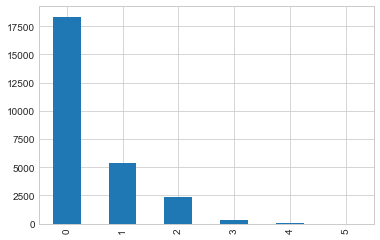

In [173]:
data_df['child_num'].value_counts(sort=False).plot.bar()

child_num -> 범주형 변수로 수정 처리
* 0 - 자녀 없음
* 1 - 자녀 1명
* 2 - 2명 이상의 다자녀

In [174]:
data_df.loc[data_df['child_num'] >= 2,'child_num']=2

<AxesSubplot:>

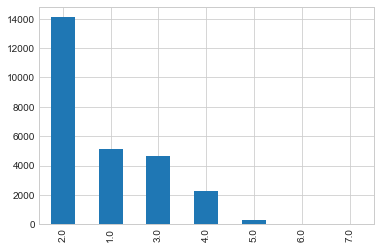

In [175]:
data_df['family_size'].value_counts().plot.bar()

In [176]:
data_df.loc[data_df['family_size'] >= 5,'family_size']=4

In [177]:
data_df.loc[data_df['family_size'] == 1,'family_category']= 'Nuclear'
data_df.loc[data_df['family_size'] >= 4,'family_category']= 'big'
data_df.loc[(data_df['family_size'] < 4) & (data_df['family_size'] >= 2),'family_category']= 'small'

### occyp_new

In [178]:
dictionary = {}
for n,occyp in enumerate(data_df.occyp_type.unique()):
    temp=data_df.loc[data_df.occyp_type==occyp ,'credit'].value_counts().values
    dictionary[occyp] = (temp/temp.sum()).round(3)*100

occyp_2 = ['Medicine staff', 'Security staff', 'Cleaning staff', 'Waiters/barmen staff', 'Secretaries', 'HR staff']
occyp_1 = ['High skill tech staff', 'Laborers', 'Sales staff', 'Accountants', 'Realty agents','Cooking staff', 'Drivers']
occyp_0 = ['Managers', 'Core staff', 'Unemployed', 'Private service staff', 'IT staff', 'Low-skill Laborers']


data_df.loc[data_df['occyp_type'].isin(occyp_0), 'occyp_category'] = 0
data_df.loc[data_df['occyp_type'].isin(occyp_1), 'occyp_category'] = 1
data_df.loc[data_df['occyp_type'].isin(occyp_2), 'occyp_category'] = 2

dictionary

{'Laborers': array([64.1, 23.6, 12.3]),
 'Managers': array([65.9, 21.1, 12.9]),
 'Sales staff': array([62.9, 25.6, 11.5]),
 'High skill tech staff': array([62.2, 26. , 11.8]),
 'Core staff': array([63.7, 23.2, 13.1]),
 'Drivers': array([65.3, 22.8, 11.9]),
 'Medicine staff': array([68.3, 22.1,  9.6]),
 'Accountants': array([61.8, 25.2, 13.1]),
 'Unemployed': array([63.5, 24.4, 12.1]),
 'Realty agents': array([69.8, 15.9, 14.3]),
 'Security staff': array([70. , 20.8,  9.2]),
 'Cleaning staff': array([66.8, 23.2, 10. ]),
 'Private service staff': array([63. , 22.6, 14.4]),
 'Cooking staff': array([63.2, 24.1, 12.7]),
 'Secretaries': array([58.8, 32. ,  9.3]),
 'HR staff': array([82.3, 11.3,  6.5]),
 'IT staff': array([56.1, 24.4, 19.5]),
 'Low-skill Laborers': array([66.1, 17.3, 16.5]),
 'Waiters/barmen staff': array([51.2, 40.7,  8.1])}

<AxesSubplot:xlabel='occyp_category', ylabel='count'>

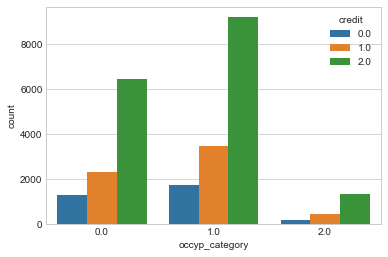

In [179]:
sns.countplot(data=data_df, x = 'occyp_category', hue = 'credit')

In [180]:
data_df.head()

,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_EMPLOYED,...,email,occyp_type,family_size,begin_month,credit,Age,dup,cards,family_category,occyp_category
index,,,,,,,,,,,,,,,,,,,,,
0,0,0,0,0,202500.0,Commercial associate,Higher education,Married,Municipal apartment,4709,...,0,Laborers,2.0,6.0,1.0,38.079452,1,5,small,1.0
1,0,0,1,1,247500.0,Commercial associate,Secondary / secondary special,Civil marriage,House / apartment,1540,...,1,Laborers,3.0,5.0,1.0,31.178082,1,9,small,1.0
2,1,1,1,0,450000.0,Working,Higher education,Married,House / apartment,4434,...,0,Managers,2.0,22.0,2.0,52.293151,1,6,small,0.0
3,0,0,1,0,202500.0,Commercial associate,Secondary / secondary special,Married,House / apartment,2092,...,0,Sales staff,2.0,37.0,0.0,41.336986,1,2,small,1.0
4,0,1,1,0,157500.0,State servant,Higher education,Married,House / apartment,2105,...,0,Managers,2.0,26.0,2.0,41.197260,0,1,small,0.0


In [181]:
data_df.columns

Index(['gender', 'car', 'reality', 'child_num', 'income_total', 'income_type',
       'edu_type', 'family_type', 'house_type', 'DAYS_EMPLOYED', 'work_phone',
       'phone', 'email', 'occyp_type', 'family_size', 'begin_month', 'credit',
       'Age', 'dup', 'cards', 'family_category', 'occyp_category'],
      dtype='object')

<AxesSubplot:>

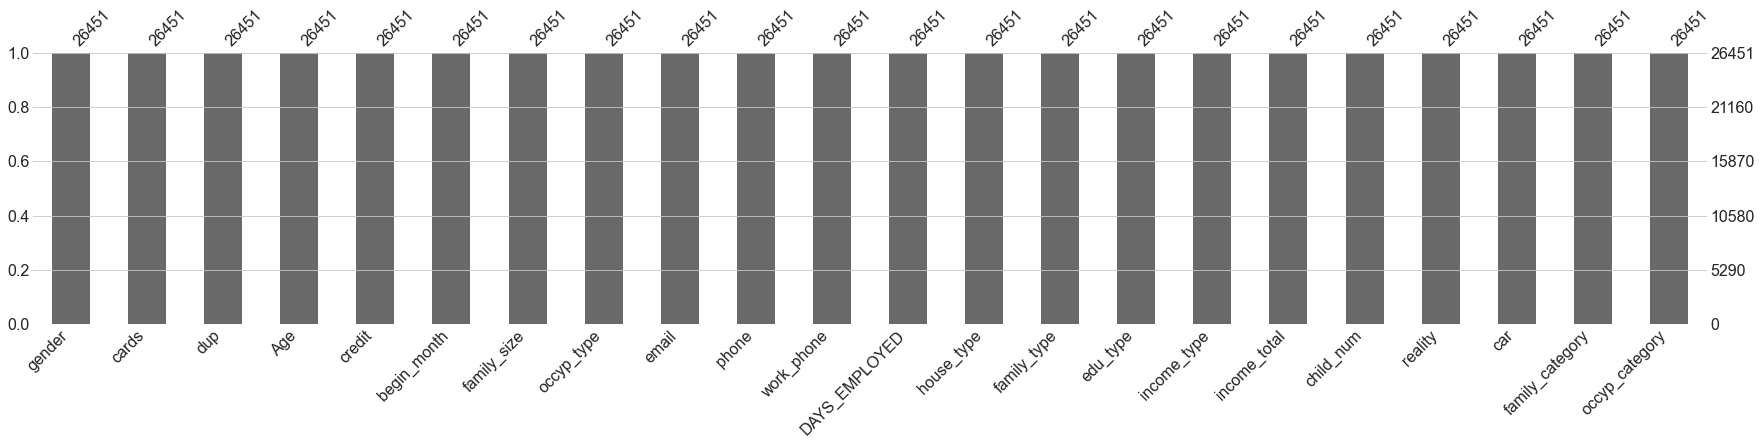

In [182]:
missingno.bar(data_df, sort='ascending', figsize = (30,5))

In [183]:
data_df

,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_EMPLOYED,...,email,occyp_type,family_size,begin_month,credit,Age,dup,cards,family_category,occyp_category
index,,,,,,,,,,,,,,,,,,,,,
0,0,0,0,0,202500.0,Commercial associate,Higher education,Married,Municipal apartment,4709,...,0,Laborers,2.0,6.0,1.0,38.079452,1,5,small,1.0
1,0,0,1,1,247500.0,Commercial associate,Secondary / secondary special,Civil marriage,House / apartment,1540,...,1,Laborers,3.0,5.0,1.0,31.178082,1,9,small,1.0
2,1,1,1,0,450000.0,Working,Higher education,Married,House / apartment,4434,...,0,Managers,2.0,22.0,2.0,52.293151,1,6,small,0.0
3,0,0,1,0,202500.0,Commercial associate,Secondary / secondary special,Married,House / apartment,2092,...,0,Sales staff,2.0,37.0,0.0,41.336986,1,2,small,1.0
4,0,1,1,0,157500.0,State servant,Higher education,Married,House / apartment,2105,...,0,Managers,2.0,26.0,2.0,41.197260,0,1,small,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26452,0,0,0,2,225000.0,State servant,Secondary / secondary special,Married,House / apartment,1984,...,0,Core staff,4.0,2.0,1.0,33.093151,1,5,big,0.0
26453,0,0,1,1,180000.0,Working,Higher education,Separated,House / apartment,2475,...,0,Laborers,2.0,47.0,2.0,41.893151,0,1,small,1.0
26454,0,1,0,0,292500.0,Working,Secondary / secondary special,Civil marriage,With parents,2015,...,0,Core staff,2.0,25.0,2.0,27.621918,0,1,small,0.0


In [184]:
data_df = data_df.reset_index().drop(['index'],axis=1)
data_df.to_csv('./pre_credit_df(fill_groupby)_final.csv')

In [185]:
data_df.head()

,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_EMPLOYED,...,email,occyp_type,family_size,begin_month,credit,Age,dup,cards,family_category,occyp_category
0,0,0,0,0,202500.0,Commercial associate,Higher education,Married,Municipal apartment,4709,...,0,Laborers,2.0,6.0,1.0,38.079452,1,5,small,1.0
1,0,0,1,1,247500.0,Commercial associate,Secondary / secondary special,Civil marriage,House / apartment,1540,...,1,Laborers,3.0,5.0,1.0,31.178082,1,9,small,1.0
2,1,1,1,0,450000.0,Working,Higher education,Married,House / apartment,4434,...,0,Managers,2.0,22.0,2.0,52.293151,1,6,small,0.0
3,0,0,1,0,202500.0,Commercial associate,Secondary / secondary special,Married,House / apartment,2092,...,0,Sales staff,2.0,37.0,0.0,41.336986,1,2,small,1.0
4,0,1,1,0,157500.0,State servant,Higher education,Married,House / apartment,2105,...,0,Managers,2.0,26.0,2.0,41.197260,0,1,small,0.0


# 시각화 자료

In [146]:
#자동으로 num과 cat 변수 갈라서 df 생성
train_cat = data_df.select_dtypes(include=np.object)
train_num = data_df.select_dtypes(exclude=np.object)

In [147]:
train_cat.shape, train_num.shape

((26451, 6), (26451, 16))

In [148]:
print("cat: \n", train_cat.columns)
print("num: \n", train_num.columns)

cat: 
 Index(['income_type', 'edu_type', 'family_type', 'house_type', 'occyp_type',
       'family_category'],
      dtype='object')
num: 
 Index(['gender', 'car', 'reality', 'child_num', 'income_total',
       'DAYS_EMPLOYED', 'work_phone', 'phone', 'email', 'family_size',
       'begin_month', 'credit', 'Age', 'dup', 'cards', 'occyp_category'],
      dtype='object')


In [149]:
#자동으로 num과 cat 변수 갈라서 df 생성
train_cat = data_df.select_dtypes(include=np.object)
train_num = data_df.select_dtypes(exclude=np.object)

# cat인데 숫자로 들어간 변수 따로 train_cat로 넣어주기
tmp = data_df[['gender','car','reality','child_num','work_phone','phone','email','dup','occyp_category']]
train_cat = pd.concat([train_cat, tmp], axis = 1)
train_cat.head(2)

#cat인데 num df에 들어간 변수 num df에서 drop해주기
train_num = train_num.drop(columns=['gender','car','reality','child_num','work_phone','phone','email','dup','occyp_category'], axis = 1)

# cat과 num 변수 빠짐없이 잘 divide 되었는지 확인하기
len(train_cat.columns) + len(train_num.columns) == len(data_df.columns) + 1

True

In [151]:
print("total cols: \n", data_df.columns, data_df.shape[1])

total cols: 
 Index(['gender', 'car', 'reality', 'child_num', 'income_total', 'income_type',
       'edu_type', 'family_type', 'house_type', 'DAYS_EMPLOYED', 'work_phone',
       'phone', 'email', 'occyp_type', 'family_size', 'begin_month', 'credit',
       'Age', 'dup', 'cards', 'family_category', 'occyp_category'],
      dtype='object') 22


In [152]:
print("cat: \n", train_cat.columns, train_cat.shape[1] )
print("num: \n", train_num.columns, train_num.shape[1])

cat: 
 Index(['income_type', 'edu_type', 'family_type', 'house_type', 'occyp_type',
       'family_category', 'gender', 'car', 'reality', 'child_num',
       'work_phone', 'phone', 'email', 'dup', 'occyp_category'],
      dtype='object') 15
num: 
 Index(['income_total', 'DAYS_EMPLOYED', 'family_size', 'begin_month', 'credit',
       'Age', 'cards'],
      dtype='object') 7


In [153]:
y_label = train_num['credit']
data_df_v=pd.concat([train_cat,y_label],axis=1).astype(object)

변수를 legend, credit을 y축에 오도록 수정하기!

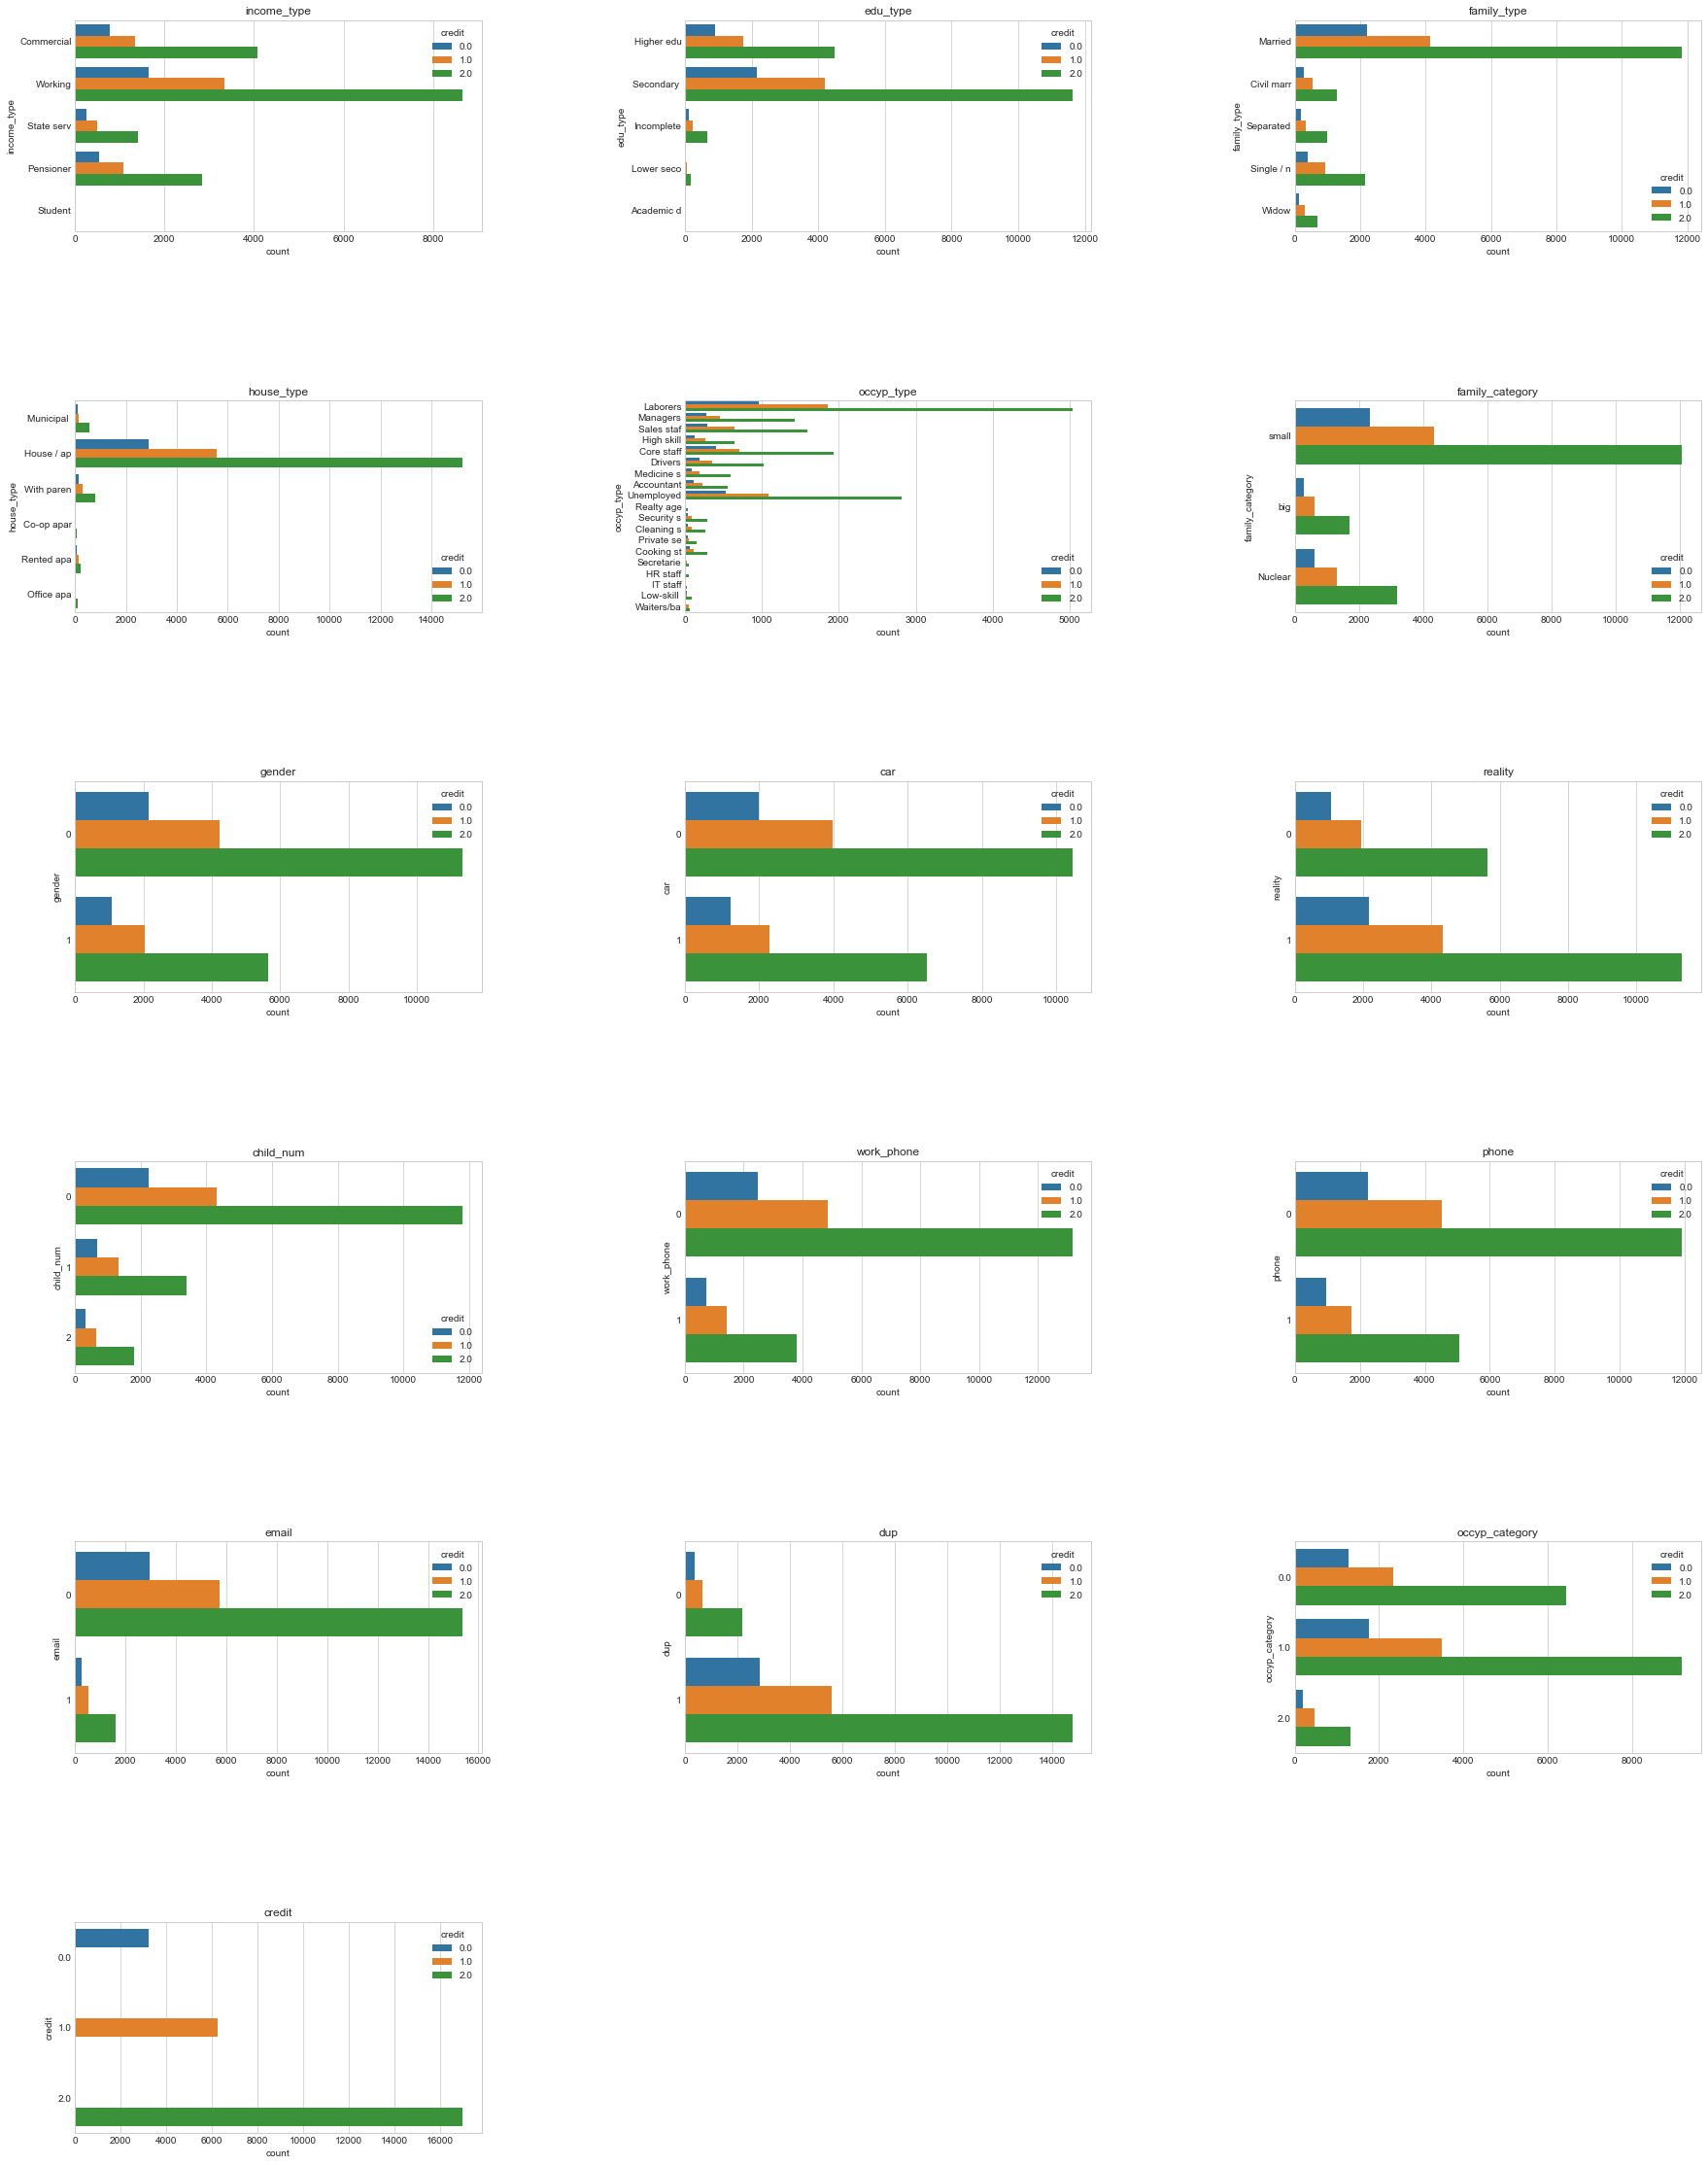

In [154]:
def plot_bivariate_bar(dataset, hue, cols=5, width=20, height=30, hspace=0.2, wspace=0.5):
    dataset = dataset.select_dtypes(include=[np.object])
    plt.style.use('seaborn-whitegrid')
    fig = plt.figure(figsize=(width,height))
    fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=wspace, hspace=hspace)
    rows = math.ceil(float(dataset.shape[1]) / cols)
    for i, column in enumerate(dataset.columns):
        ax = fig.add_subplot(rows, cols, i + 1)
        ax.set_title(column)
        if dataset.dtypes[column] == np.object:
            g = sns.countplot(y=column, hue=hue, data=dataset)
            substrings = [s.get_text()[:10] for s in g.get_yticklabels()]
            g.set(yticklabels=substrings)

plot_bivariate_bar(data_df_v, hue='credit', cols=3, width=30, height=40, hspace=0.8, wspace=0.5)

In [186]:
tmp = pd.read_csv('pre_credit_df(fill_groupby)_final.csv')
tmp.columns

Index(['Unnamed: 0', 'gender', 'car', 'reality', 'child_num', 'income_total',
       'income_type', 'edu_type', 'family_type', 'house_type', 'DAYS_EMPLOYED',
       'work_phone', 'phone', 'email', 'occyp_type', 'family_size',
       'begin_month', 'credit', 'Age', 'dup', 'cards', 'family_category',
       'occyp_category'],
      dtype='object')

In [187]:
tmp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26451 entries, 0 to 26450
Data columns (total 23 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Unnamed: 0       26451 non-null  int64  
 1   gender           26451 non-null  int64  
 2   car              26451 non-null  int64  
 3   reality          26451 non-null  int64  
 4   child_num        26451 non-null  int64  
 5   income_total     26451 non-null  float64
 6   income_type      26451 non-null  object 
 7   edu_type         26451 non-null  object 
 8   family_type      26451 non-null  object 
 9   house_type       26451 non-null  object 
 10  DAYS_EMPLOYED    26451 non-null  int64  
 11  work_phone       26451 non-null  int64  
 12  phone            26451 non-null  int64  
 13  email            26451 non-null  int64  
 14  occyp_type       26451 non-null  object 
 15  family_size      26451 non-null  float64
 16  begin_month      26451 non-null  float64
 17  credit      